In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pathlib as pal
import nibabel as nib
import ptitprince as pt
from scipy import io as sio
import sklearn.metrics as skm
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
from matplotlib.colors import ListedColormap

In [3]:
# Paths
root_p = pal.Path('.')
data_p = root_p / '../data/'
atlas_p = pal.Path('/home/surchs/data/ATLAS/MIST/Parcellations/')
mask_p = atlas_p / 'MIST_mask.nii.gz'
mist_t = 'MIST_{}.nii.gz'
release_p = pal.Path('/mnt/data_sq/cisl/ATLAS/MIST/Parcellations/')
original_basc_p = data_p / 'cambridge/cambridge_atlas/out/stability_group/'
rep_region1_p = data_p / 'cambridge/cambridge_region_1/stability_group/'
rep_region2_p = data_p / 'cambridge/cambridge_region_2/stability_group/'
gsp_region1_p = data_p / 'basc/gsp_region1/stability_group/'
gsp_region2_p = data_p / 'basc/gsp_region2/stability_group/'

In [4]:
mask_i = nib.load(str(mask_p))
mask = mask_i.get_data().astype(bool)

In [5]:
resolutions = [7, 12, 20, 36, 64, 122, 197, 325, 444]

In [6]:
atlases = {res:nib.load(str(atlas_p / mist_t.format(res))).get_data().astype(int) for res in resolutions}
atlases_img = {res:nib.load(str(atlas_p / mist_t.format(res))) for res in resolutions}

In [7]:
def get_max_dice(reference, mask):
    candidates = np.unique(reference[mask])
    return np.max([skm.f1_score(reference==cand, mask) for cand in candidates])

In [8]:
def make_dice(path1, path2, mask):
    comp1 = nib.load(str(path1.resolve())).get_data()[mask]
    comp2 = nib.load(str(path2.resolve())).get_data()[mask]
    dice_max = [get_max_dice(comp2, comp1==j) for j in np.unique(comp1)]
    return dice_max

In [29]:
# Compute the DICE
dices = {name:list() for name in ['or1', 'or2', 'og1', 'og2']}
for res in resolutions:
    o_p = list(original_basc_p.glob('*scf{0}/brain_partition_consensus*scf{0}.nii.gz'.format(res)))[0]
    r1_p = list(rep_region1_p.glob('*scf{0}/brain_partition_consensus*scf{0}.nii.gz'.format(res)))[0]
    r2_p = list(rep_region2_p.glob('*scf{0}/brain_partition_consensus*scf{0}.nii.gz'.format(res)))[0]
    g1_p = list(gsp_region1_p.glob('*scf{0}/brain_partition_consensus*scf{0}.nii.gz'.format(res)))[0]
    g2_p = list(gsp_region2_p.glob('*scf{0}/brain_partition_consensus*scf{0}.nii.gz'.format(res)))[0]
    
    or1 = make_dice(o_p, r1_p, mask)
    or2 = make_dice(o_p, r2_p, mask)
    og1 = make_dice(o_p, g1_p, mask)
    og2 = make_dice(o_p, g2_p, mask)
    
    dices['or1'].append(or1)
    dices['or2'].append(or2)
    dices['og1'].append(og1)
    dices['og2'].append(og2)
    
    print(res)

7
12
20
36
64
122
197
325
444


## Investigate the Split-half replication

In [30]:
flat_or1 = [[val, res_name] for res_id, res_name in enumerate(resolutions) for val in dices['or1'][res_id]]
or1 = pd.DataFrame(data=flat_or1, columns=['dice', 'resolution'])
flat_or2 = [[val, res_name] for res_id, res_name in enumerate(resolutions) for val in dices['or2'][res_id]]
or2 = pd.DataFrame(data=flat_or2, columns=['dice', 'resolution'])

In [107]:
md1 = [np.mean(i) for i in dices['or1']]
md2 = [np.mean(i) for i in dices['or2']]

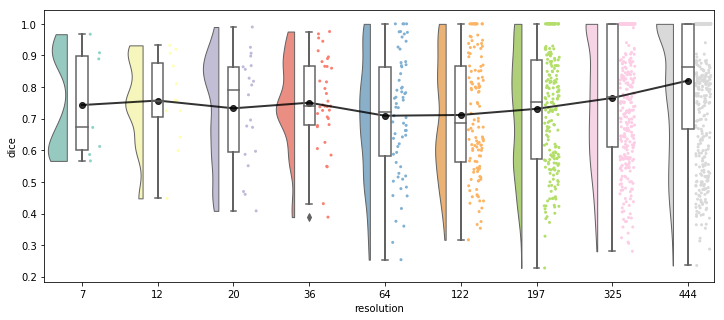

In [108]:
ort = "v"
pal = "Set3"
sigma = 0.3
g = pt.RainCloud(x='resolution', y='dice', data=or1, palette = pal, bw = sigma,
                 width_viol = .5, figsize = (12,5), orient = ort, move = 0.2)
g.plot(np.arange(len(resolutions)), md1, zorder=1, linewidth=2, color='black', marker='o', alpha=0.8);

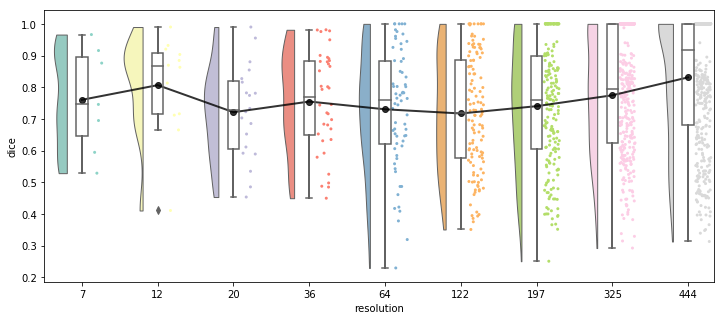

In [109]:
ort = "v"
pal = "Set3"
sigma = 0.4
g = pt.RainCloud(x='resolution', y='dice', data=or2, palette = pal, bw = sigma,
                 width_viol = .5, figsize = (12,5), orient = ort, move = 0.2, pointplot=False)
g.plot(np.arange(len(resolutions)), md2, zorder=1, linewidth=2, color='black', marker='o', alpha=0.8);

In [ ]:
flat_og1 = [[val, roi_name] for roi_id, roi_name in enumerate(resolutions) for val in dices['og1'][roi_id]]
og1 = pd.DataFrame(data=flat_og1, columns=['dice', 'resolution'])
flat_og2 = [[val, roi_name] for roi_id, roi_name in enumerate(resolutions) for val in dices['og2'][roi_id]]
og2 = pd.DataFrame(data=flat_og2, columns=['dice', 'resolution'])

In [35]:
# Map the dice back into the brain volume
list_or1 = list()
for res_id, res in enumerate(resolutions):
    dl = dices['or1'][res_id]
    atl = atlases[res]
    tmp = np.zeros(atlases[res].shape)
    for roi in np.unique(atl[atl!=0]):
        tmp[atl==roi] = dl[roi-1]
    tmp_i = nib.Nifti1Image(tmp, mask_i.affine, header=mask_i.header)
    list_or1.append(tmp_i)

In [36]:
# Map the dice back into the brain volume
list_or2 = list()
for res_id, res in enumerate(resolutions):
    dl = dices['or2'][res_id]
    atl = atlases[res]
    tmp = np.zeros(atlases[res].shape)
    for roi in np.unique(atl[atl!=0]):
        tmp[atl==roi] = dl[roi-1]
    tmp_i = nib.Nifti1Image(tmp, mask_i.affine, header=mask_i.header)
    list_or2.append(tmp_i)

In [58]:
# Map the dice back into the brain for the two
list_og1 = list()
for rid, res in enumerate(resolutions):
    dl = dices['og2'][rid]
    atl = atlases[res]
    tmp = np.zeros(atlases[res].shape)
    for roi_id, roi in enumerate(np.unique(atl[atl!=0])):
        tmp[atl==roi] = dl[roi_id]
    tmp_i = nib.Nifti1Image(tmp, mask_i.affine, header=mask_i.header)
    list_og1.append(tmp_i)

In [59]:
# Map the dice back into the brain for the two
list_og2 = list()
for rid, res in enumerate(resolutions):
    dl = dices['og2'][rid]
    atl = atlases[res]
    tmp = np.zeros(atlases[res].shape)
    for roi_id, roi in enumerate(np.unique(atl[atl!=0])):
        tmp[atl==roi] = dl[roi_id]
    tmp_i = nib.Nifti1Image(tmp, mask_i.affine, header=mask_i.header)
    list_og2.append(tmp_i)

In [48]:
def make_column_figure(ovl_l, ovl_r, mist, mist_scale):
    f = plt.figure(figsize=(20,10))
    grids = gs.GridSpec(nrows=3, ncols=2, hspace=0.3, wspace=0)
    cuts = [
    (5, 0, 10),
    (-20, -20, -5),
    (20, 20, 50)
    ]
    for i in range(3):
        ax_l = f.add_subplot(grids[i, 0])
        ax_r = f.add_subplot(grids[i, 1])
        display_left = nlp.plot_stat_map(ovl_l, cut_coords=cuts[i], 
                                         draw_cross=False, cmap=double_viridis, axes=ax_l, vmax=1);
        display_left.add_contours(mist, antialiased=False,
                             linewidths=0.1, levels=np.arange(mist_scale)+1, colors=['black'], alpha=0.8);
        
        display_right = nlp.plot_stat_map(ovl_r, cut_coords=cuts[i], colorbar=False, 
                                          draw_cross=False, axes=ax_r, cmap=double_viridis, vmax=1);
        display_right.add_contours(mist, antialiased=False,
                         linewidths=0.1, levels=np.arange(mist_scale)+1, colors=['black'], alpha=0.8);
    f.suptitle('Scale {}'.format(mist_scale))
        
    return f

In [44]:
colors = plt.cm.get_cmap('viridis_r').colors
new_colors = colors + colors[::-1]
double_viridis = ListedColormap(new_colors, name='double_viridis')

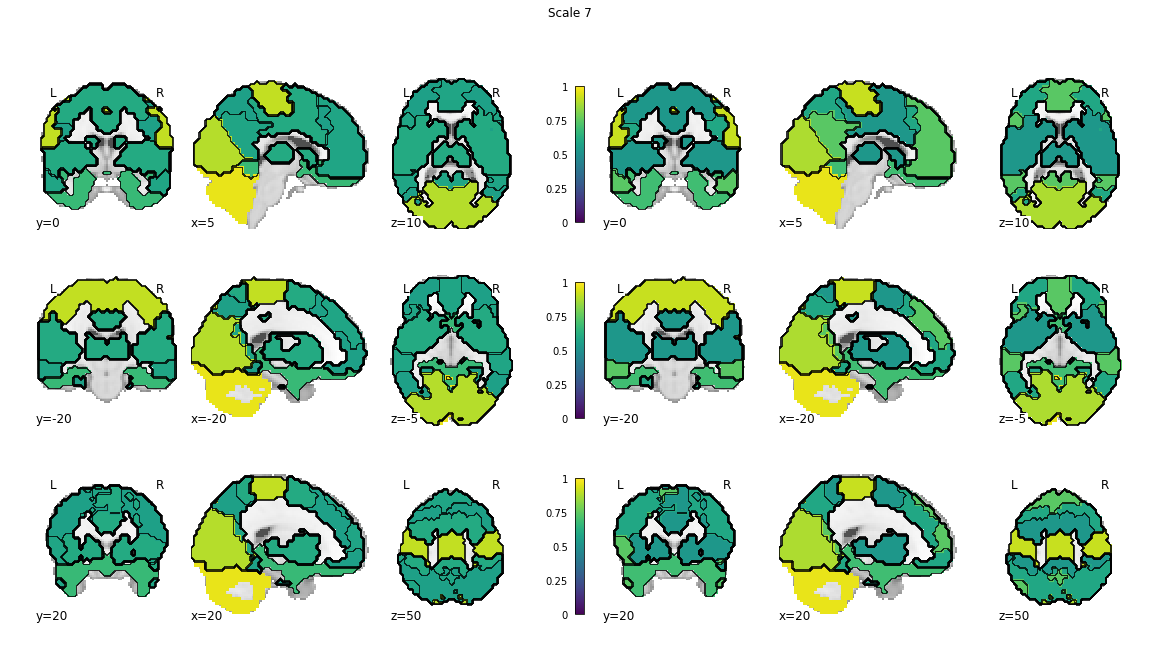

In [49]:
res_id = 0
res = resolutions[res_id]
q = make_column_figure(list_or1[res_id], list_or2[res_id], atlases_img[res], res)

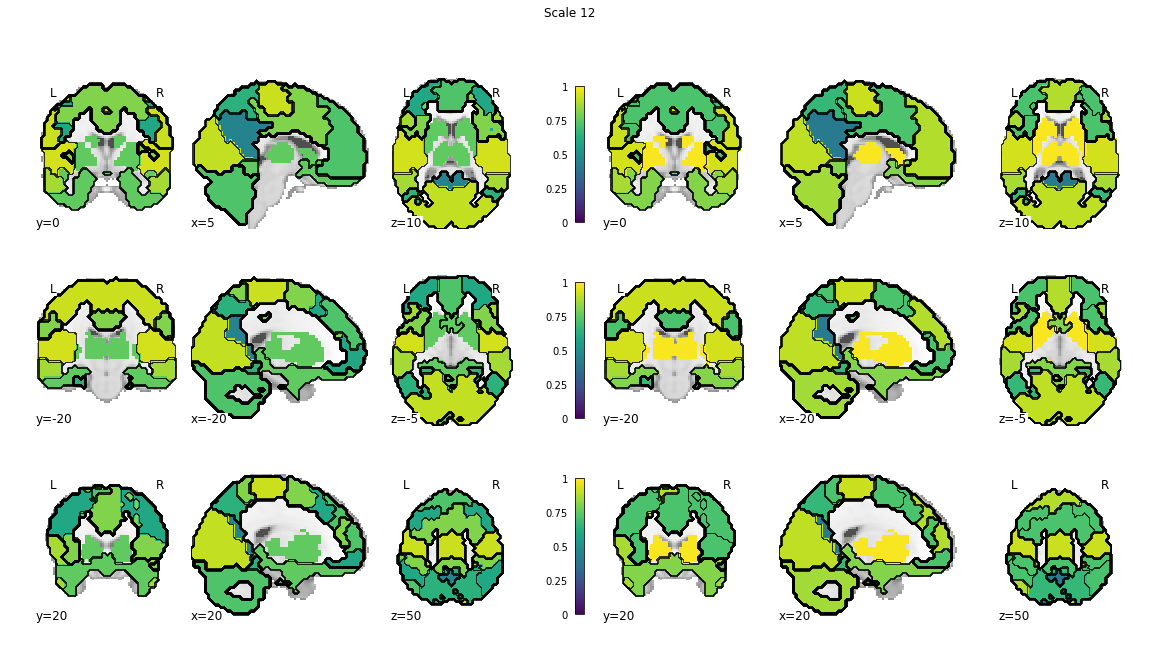

In [50]:
res_id = 1
res = resolutions[res_id]
q = make_column_figure(list_or1[res_id], list_or2[res_id], atlases_img[res], res)

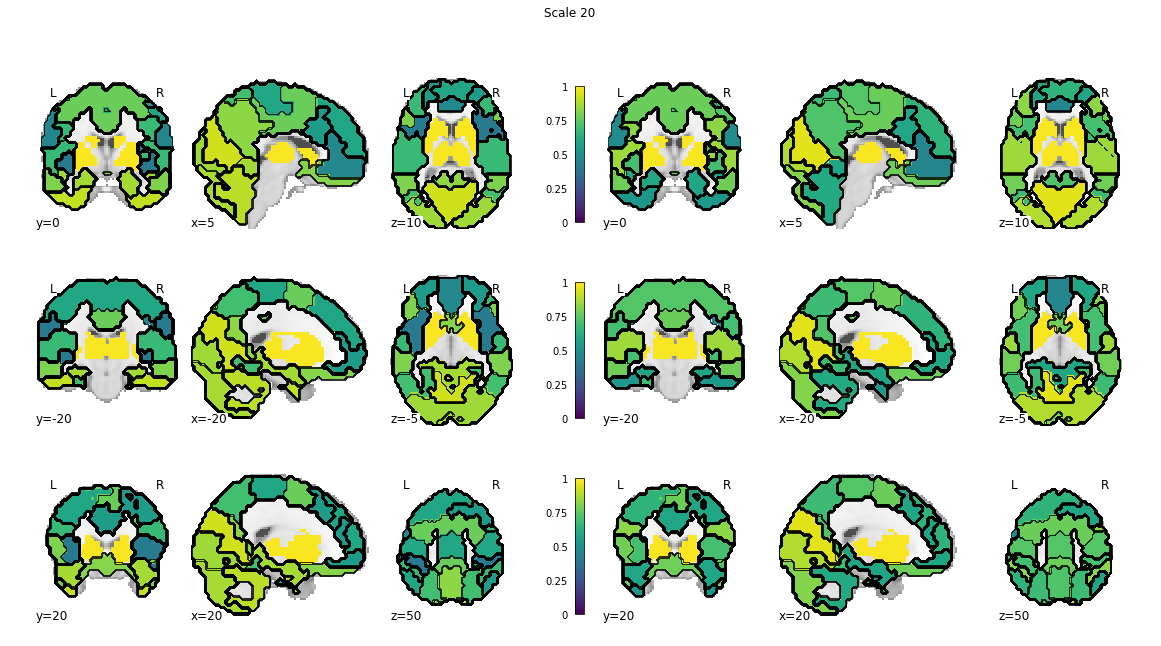

In [51]:
res_id = 2
res = resolutions[res_id]
q = make_column_figure(list_or1[res_id], list_or2[res_id], atlases_img[res], res)

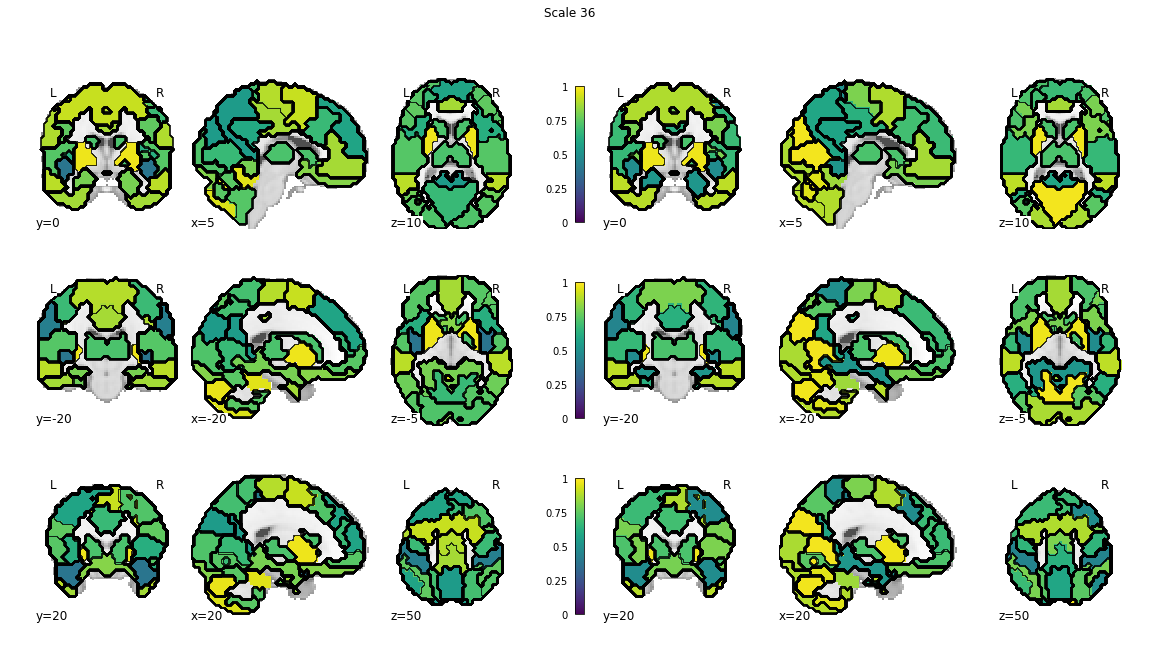

In [52]:
res_id = 3
res = resolutions[res_id]
q = make_column_figure(list_or1[res_id], list_or2[res_id], atlases_img[res], res)

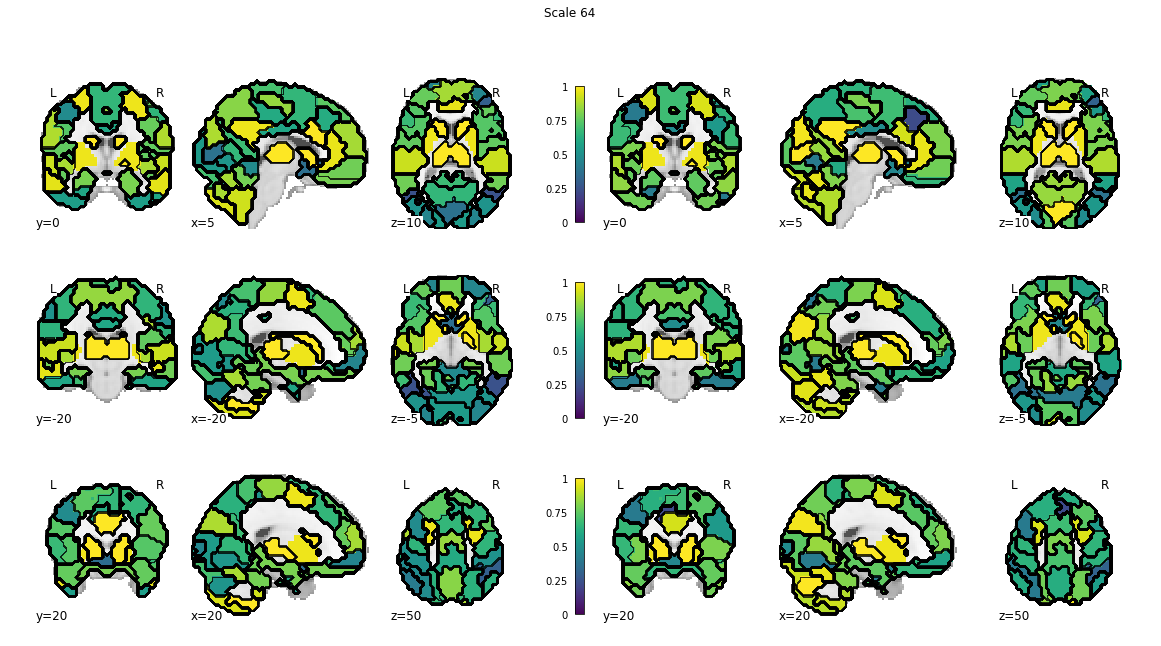

In [53]:
res_id = 4
res = resolutions[res_id]
q = make_column_figure(list_or1[res_id], list_or2[res_id], atlases_img[res], res)

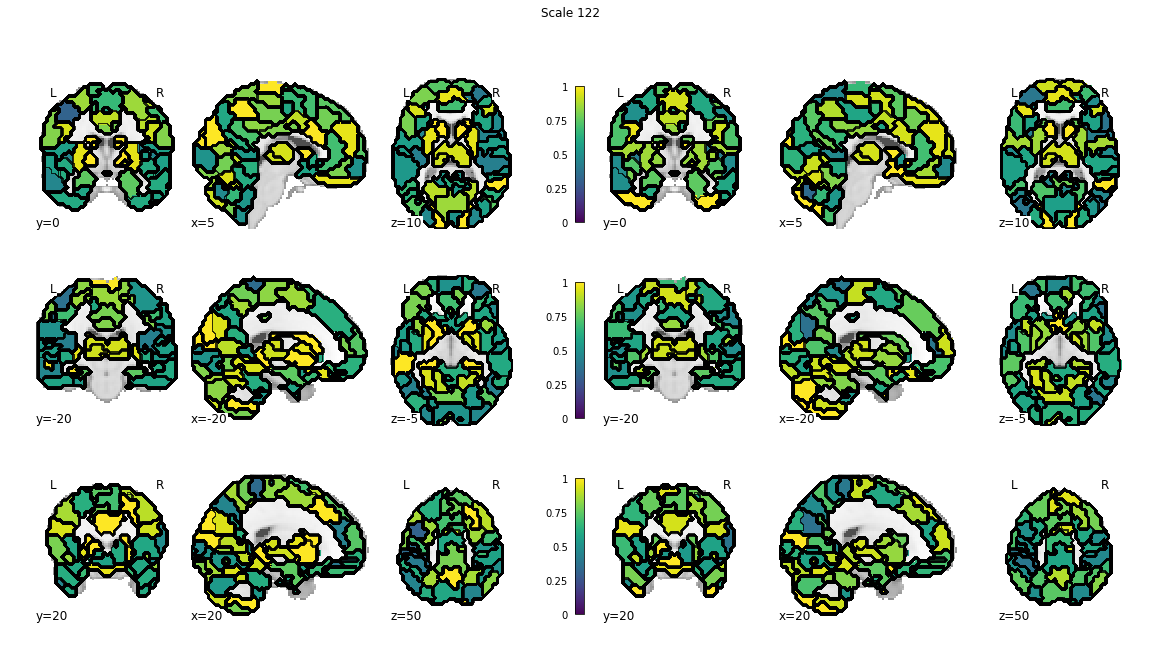

In [54]:
res_id = 5
res = resolutions[res_id]
q = make_column_figure(list_or1[res_id], list_or2[res_id], atlases_img[res], res)

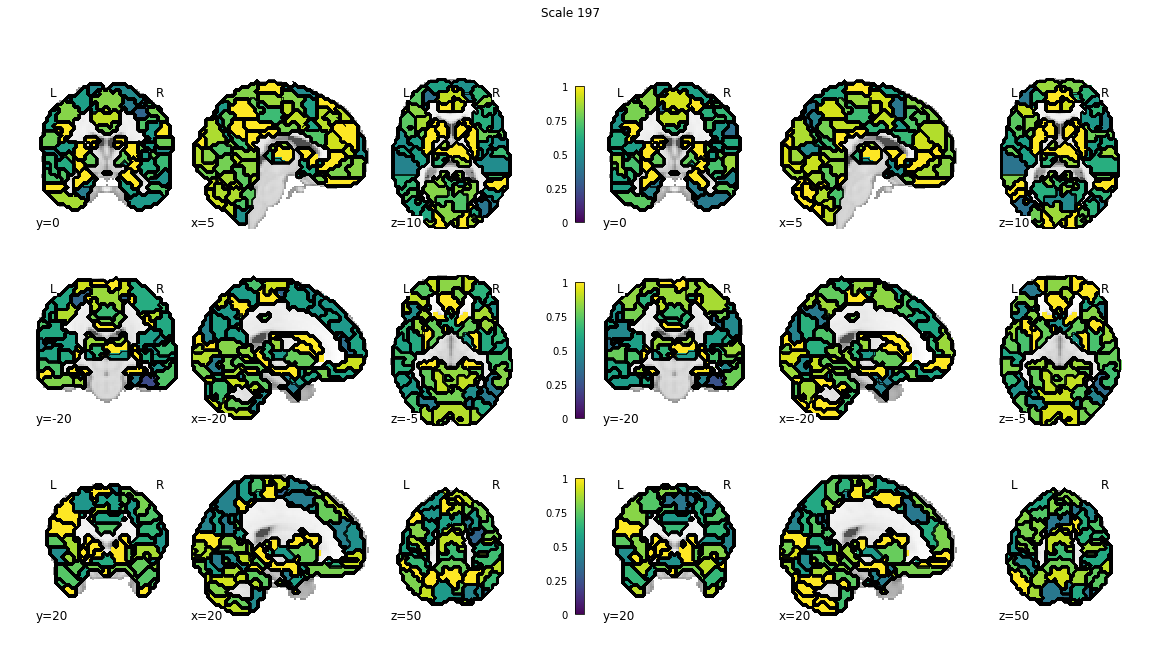

In [55]:
res_id = 6
res = resolutions[res_id]
q = make_column_figure(list_or1[res_id], list_or2[res_id], atlases_img[res], res)

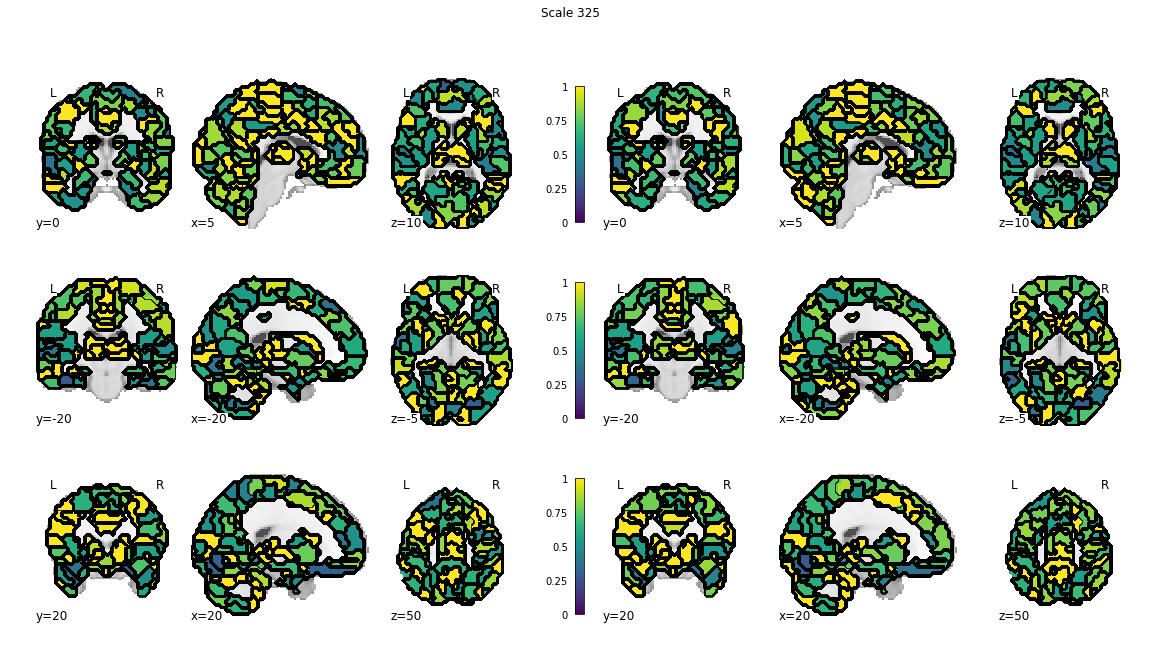

In [56]:
res_id = 7
res = resolutions[res_id]
q = make_column_figure(list_or1[res_id], list_or2[res_id], atlases_img[res], res)

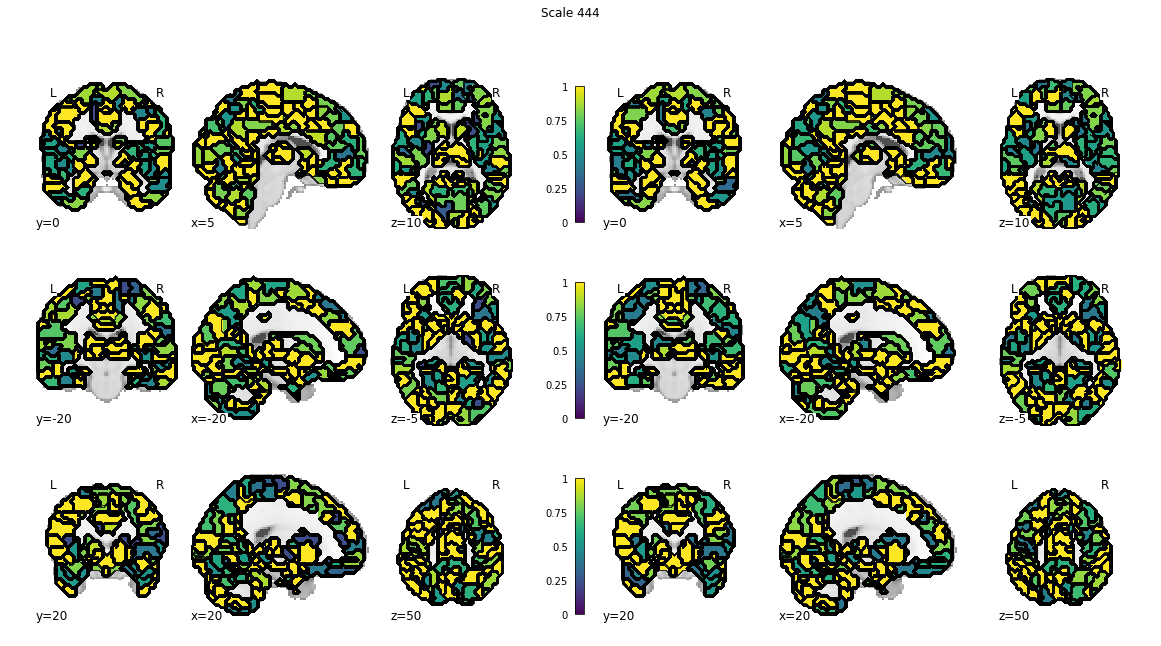

In [57]:
res_id = 8
res = resolutions[res_id]
q = make_column_figure(list_or1[res_id], list_or2[res_id], atlases_img[res], res)

## Investigate the replication analysis in GSP

In [129]:
flat_og1 = [[val, res_name] for res_id, res_name in enumerate(resolutions) for val in dices['og1'][res_id]]
og1 = pd.DataFrame(data=flat_og1, columns=['dice', 'resolution'])
flat_og2 = [[val, res_name] for res_id, res_name in enumerate(resolutions) for val in dices['og2'][res_id]]
og2 = pd.DataFrame(data=flat_og2, columns=['dice', 'resolution'])

In [130]:
mdg1 = [np.mean(i) for i in dices['og1']]
mdg2 = [np.mean(i) for i in dices['og2']]

In [150]:
md = np.concatenate((np.array(md1)[None, :], np.array(md2)[None, :]))
md_avg = np.mean(md, 0)

mdg = np.concatenate((np.array(mdg1)[None, :], np.array(mdg2)[None, :]))
mdg_avg = np.mean(mdg, 0)

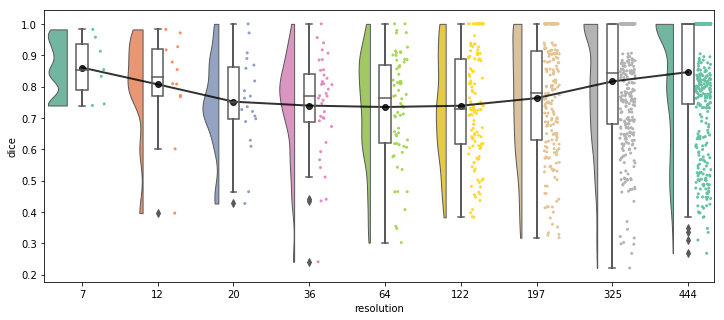

In [139]:
ort = "v"
pal = "Set2"
sigma = 0.3
g = pt.RainCloud(x='resolution', y='dice', data=og1, palette = pal, bw = sigma,
                 width_viol = .5, figsize = (12,5), orient = ort, move = 0.2)
g.plot(np.arange(len(resolutions)), mdg1, zorder=1, linewidth=2, color='black', marker='o', alpha=0.8);

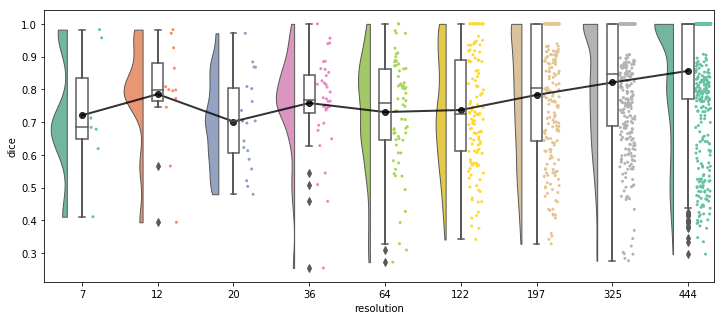

In [140]:
ort = "v"
pal = "Set2"
sigma = 0.3
g = pt.RainCloud(x='resolution', y='dice', data=og2, palette = pal, bw = sigma,
                 width_viol = .5, figsize = (12,5), orient = ort, move = 0.2)
g.plot(np.arange(len(resolutions)), mdg2, zorder=1, linewidth=2, color='black', marker='o', alpha=0.8);

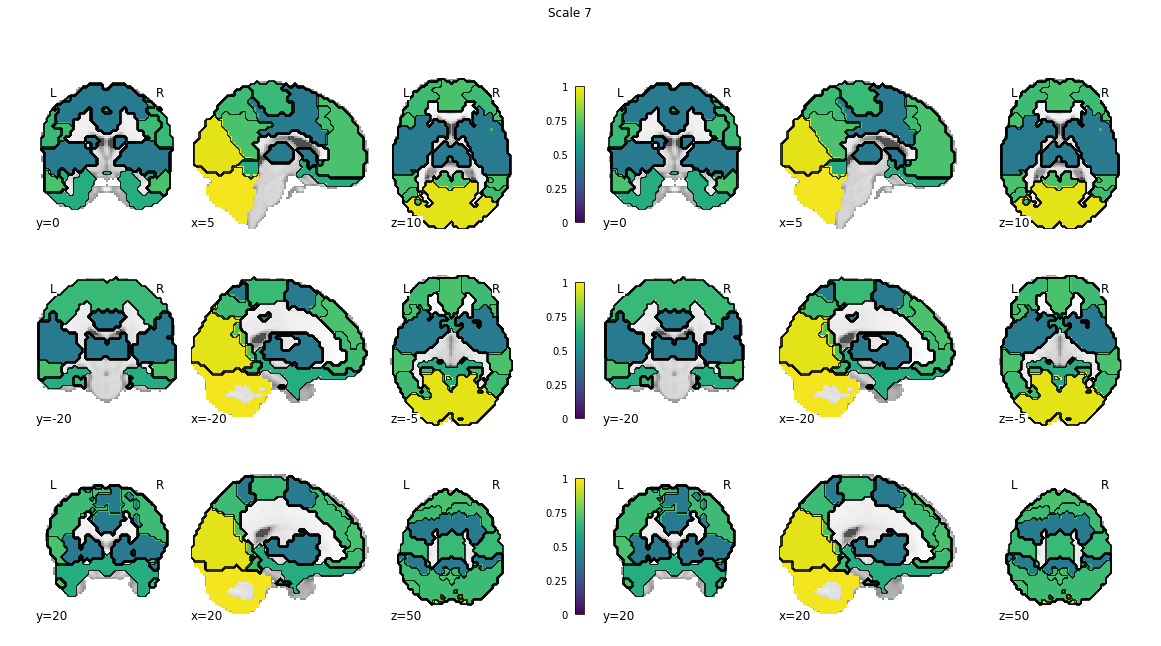

In [120]:
res_id = 0
res = resolutions[res_id]
q = make_column_figure(list_og1[res_id], list_og2[res_id], atlases_img[res], res)

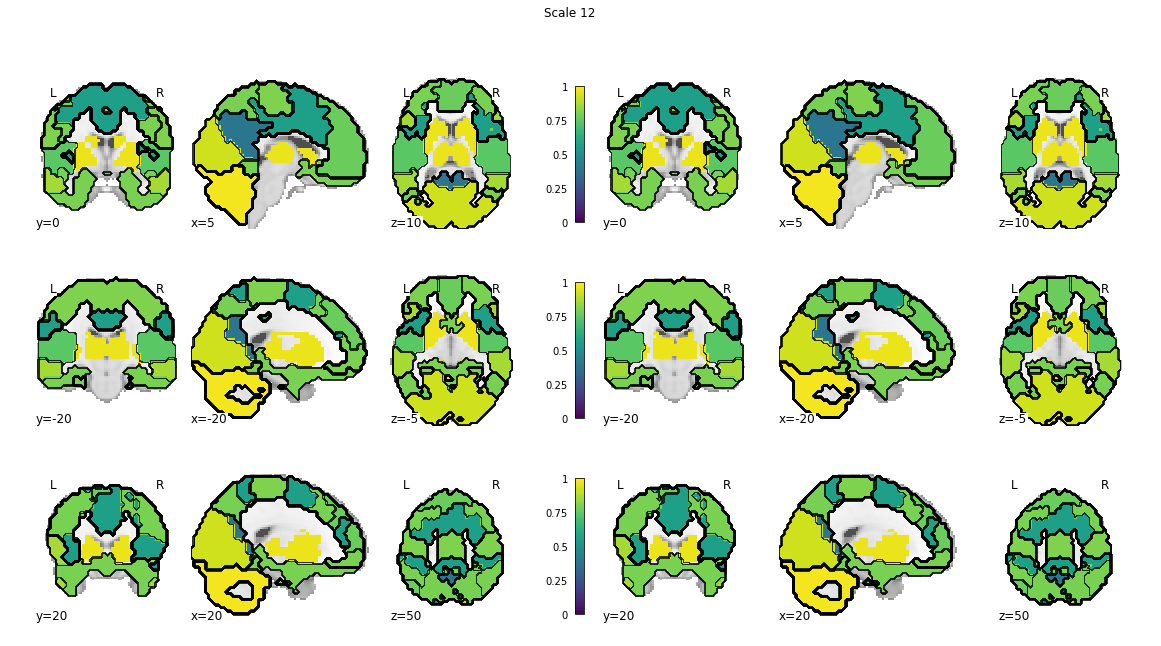

In [121]:
res_id = 1
res = resolutions[res_id]
q = make_column_figure(list_og1[res_id], list_og2[res_id], atlases_img[res], res)

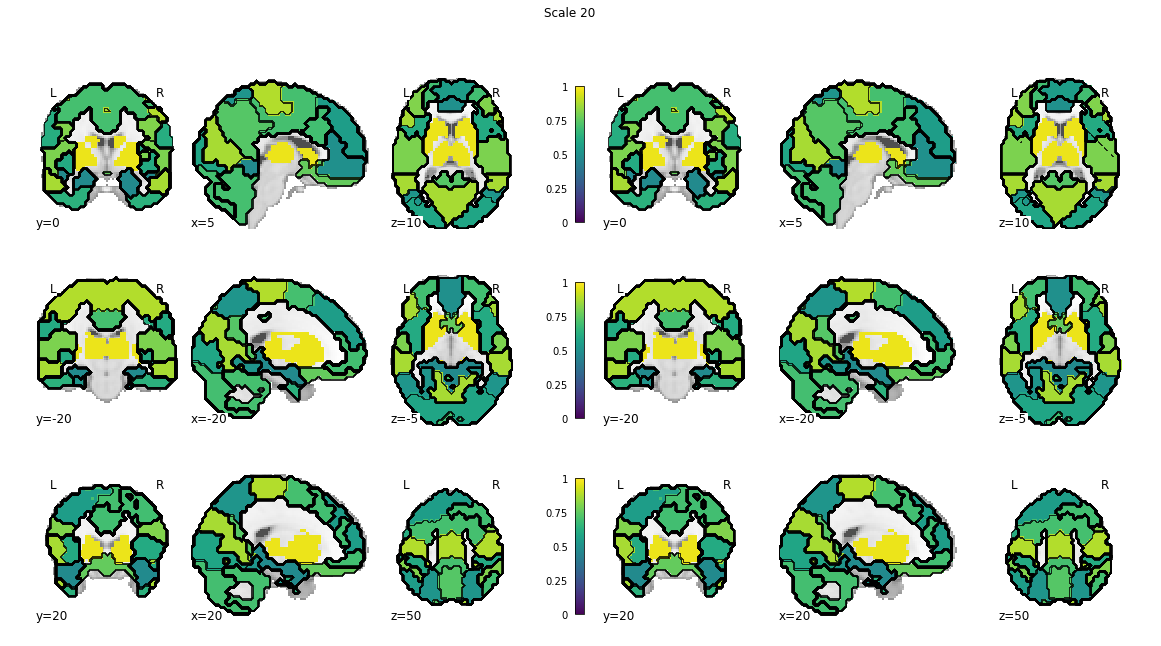

In [122]:
res_id = 2
res = resolutions[res_id]
q = make_column_figure(list_og1[res_id], list_og2[res_id], atlases_img[res], res)

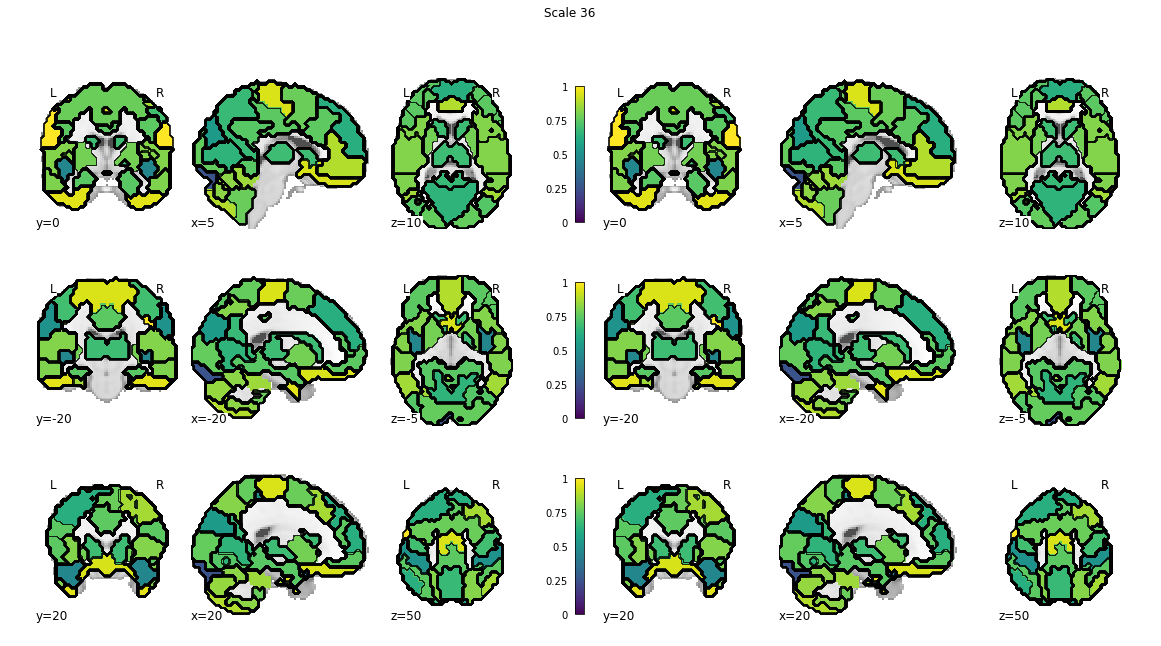

In [123]:
res_id = 3
res = resolutions[res_id]
q = make_column_figure(list_og1[res_id], list_og2[res_id], atlases_img[res], res)

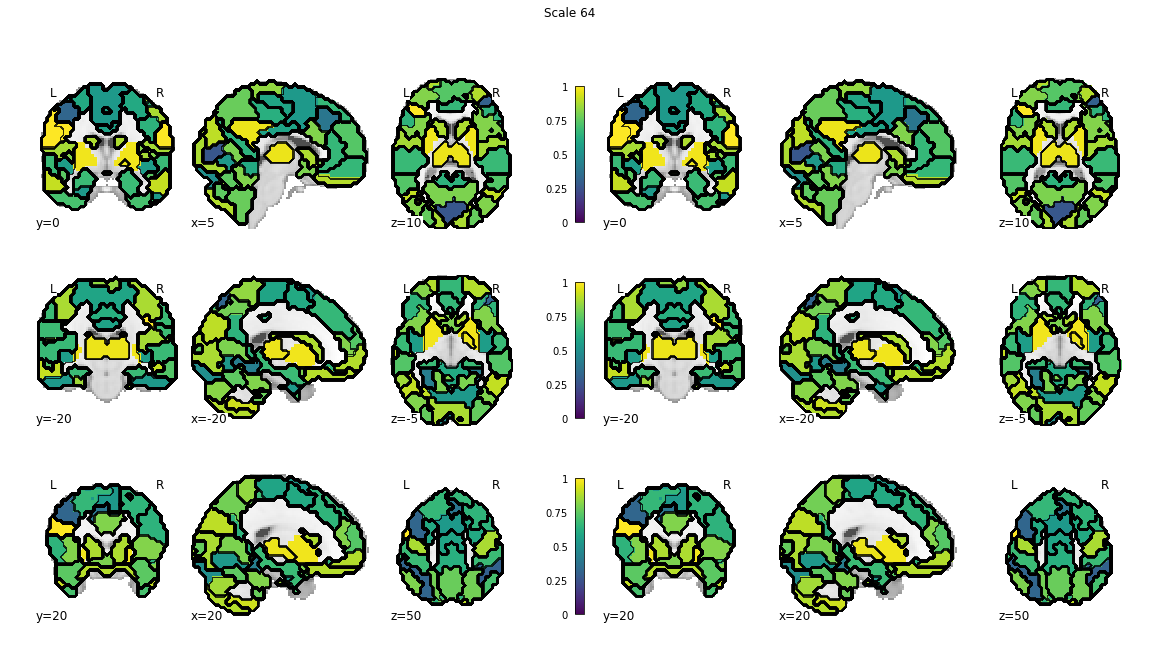

In [124]:
res_id = 4
res = resolutions[res_id]
q = make_column_figure(list_og1[res_id], list_og2[res_id], atlases_img[res], res)

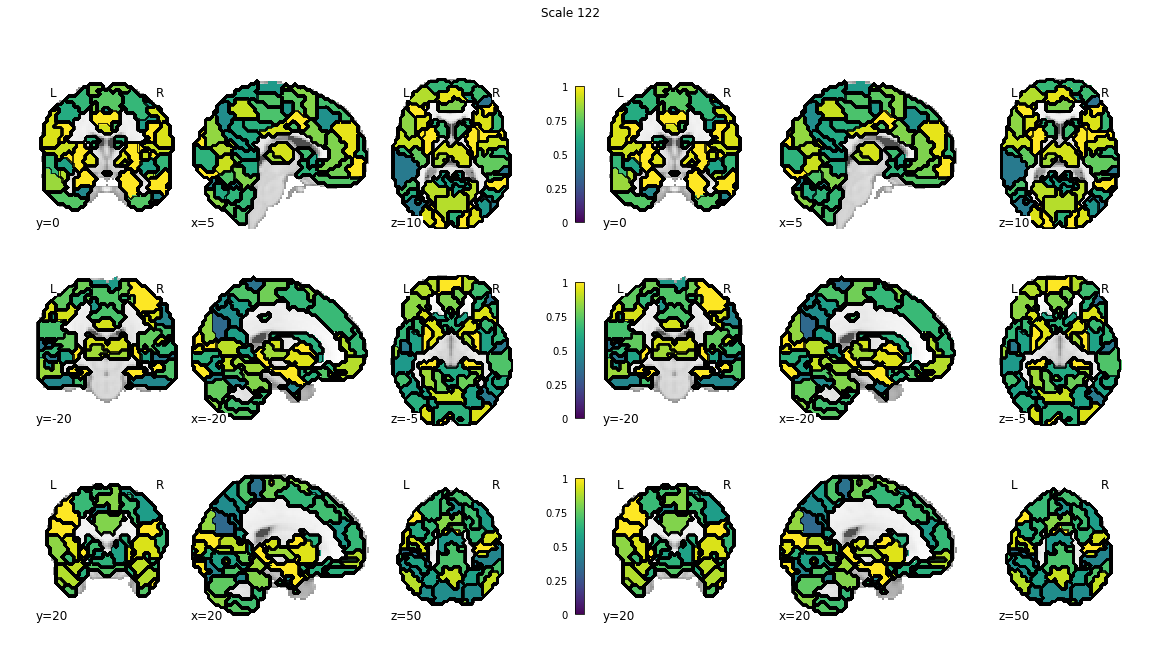

In [125]:
res_id = 5
res = resolutions[res_id]
q = make_column_figure(list_og1[res_id], list_og2[res_id], atlases_img[res], res)

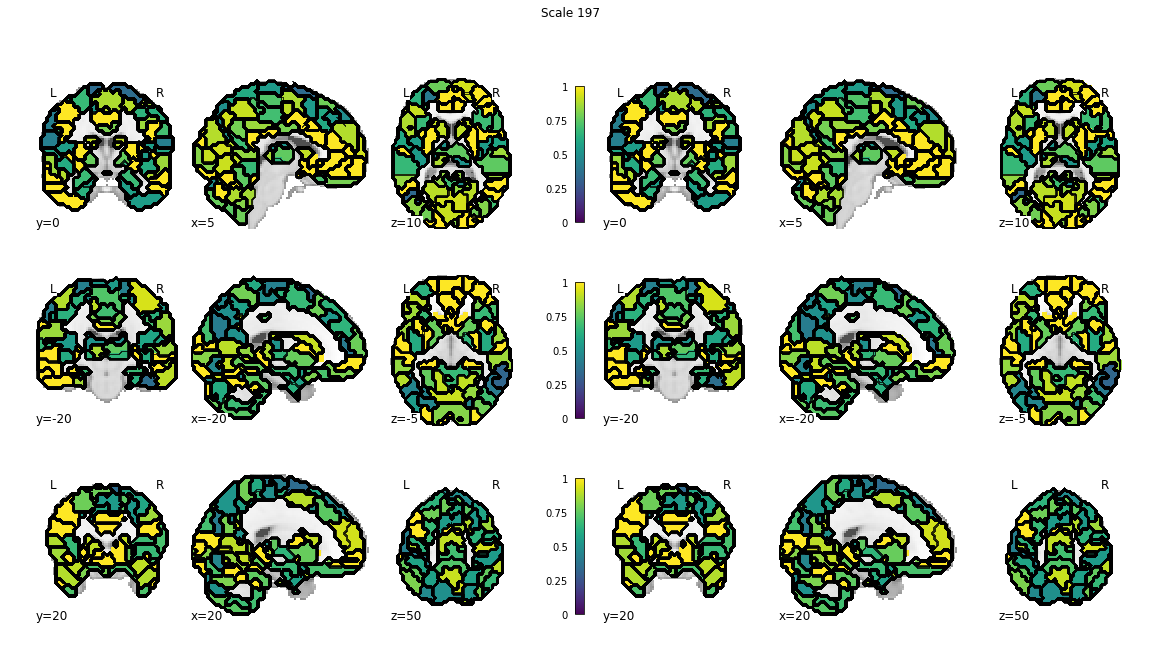

In [126]:
res_id = 6
res = resolutions[res_id]
q = make_column_figure(list_og1[res_id], list_og2[res_id], atlases_img[res], res)

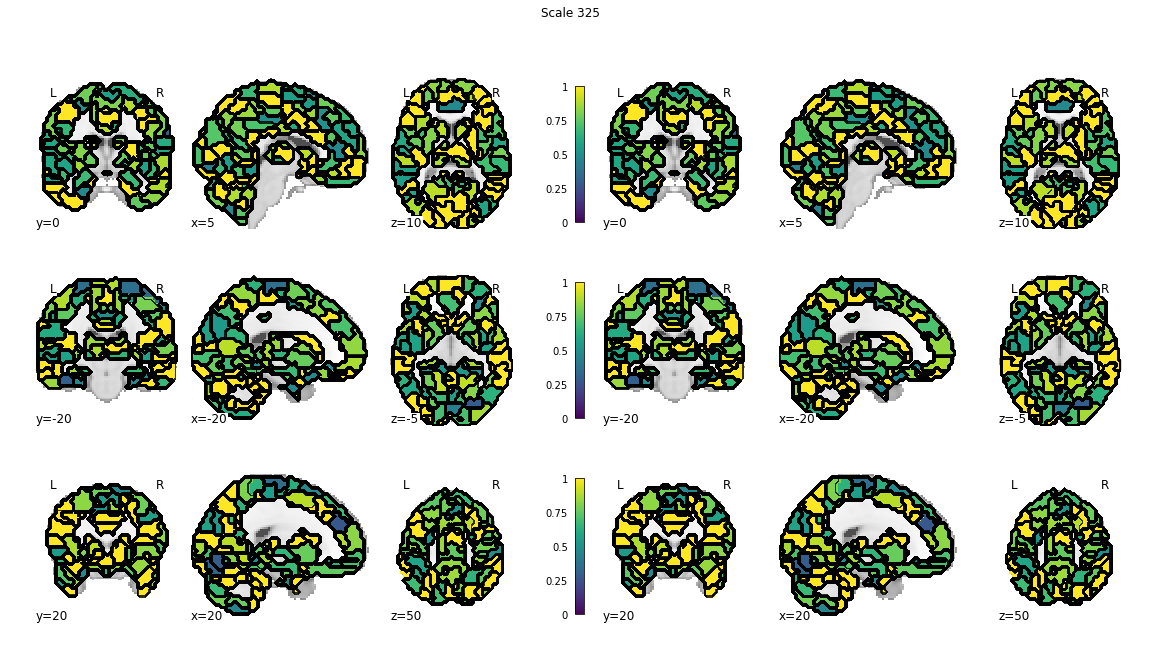

In [127]:
res_id = 7
res = resolutions[res_id]
q = make_column_figure(list_og1[res_id], list_og2[res_id], atlases_img[res], res)

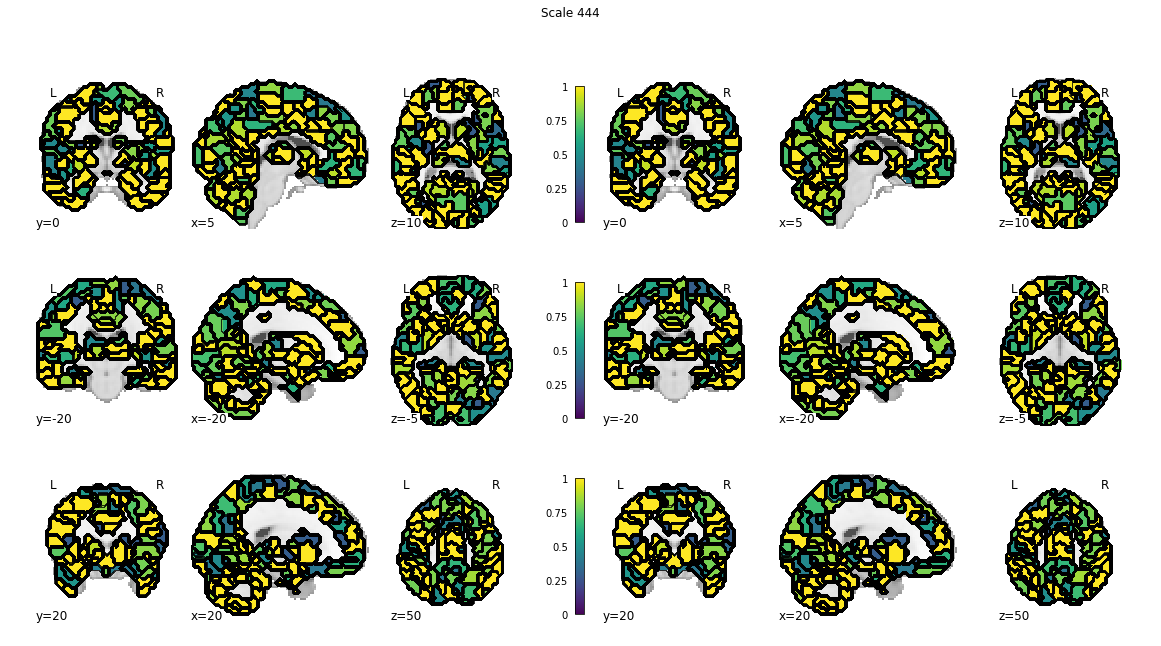

In [128]:
res_id = 8
res = resolutions[res_id]
q = make_column_figure(list_og1[res_id], list_og2[res_id], atlases_img[res], res)